In [2]:
!pip install tpot

In [18]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
import dill as pickle  # dill extends pickle

from sklearn.model_selection import RepeatedKFold, train_test_split
from tpot import TPOTRegressor

In [5]:
path_data = "/content/drive/MyDrive/AutoML/insurance.csv"
df = pd.read_csv(path_data)

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Correlation Analysis

In [7]:
categorical = df.select_dtypes('object').columns
numerical = df.drop(categorical, axis = 1).columns

In [8]:
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

<ipython-input-9-fe43fffaf13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

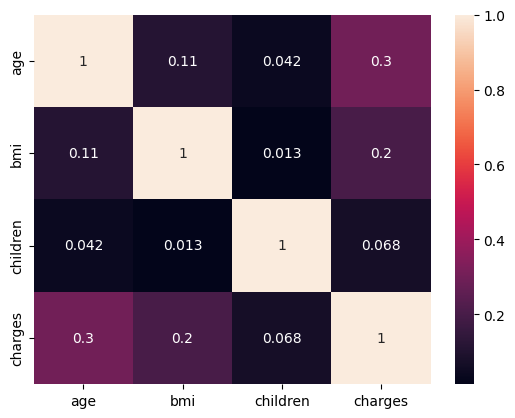

In [9]:
sns.heatmap(df.corr(), annot = True)

<Axes: >

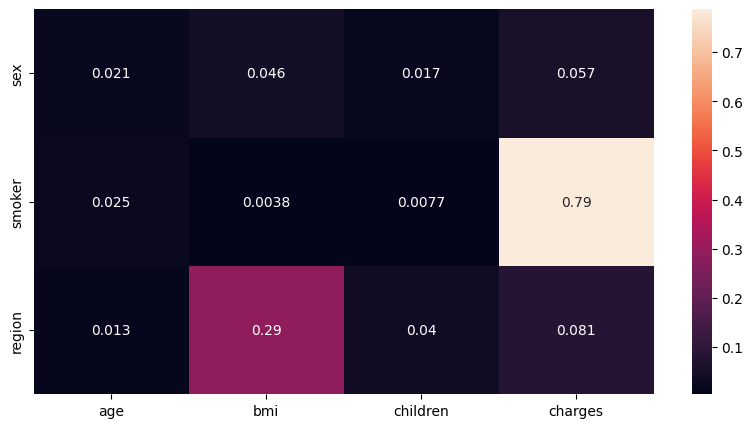

In [10]:
corrNumCat = []

for i in categorical:
    mat2 = []
    for j in numerical:
        mat2.append(correlation_ratio(df[i],df[j]))
    corrNumCat.append(mat2)

dfcramers = pd.DataFrame(corrNumCat, index = categorical, columns = numerical)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

In our correlation analysis, as we can see, the features that have a high correlated with charges is features: smoker, bmi, and age

# Build Automated Machine Learning with TPOT

In [11]:
X = df[['smoker', 'age', 'bmi']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train_preprocess = pd.get_dummies(X_train)
X_test_preprocess = pd.get_dummies(X_test)

In [12]:
X_train_preprocess.head()

,age,bmi,smoker_no,smoker_yes
804,23,26.510,1,0
354,18,38.280,1,0
563,50,44.770,1,0
1177,40,27.400,1,0
390,48,35.625,1,0


In [13]:
tpot = TPOTRegressor(subsample = 0.8, verbosity = 2, warm_start = True, early_stop = 20, max_time_mins = 30, n_jobs = -1,
                    scoring = 'r2')

tpot.fit(X_train_preprocess, y_train)
tpot.score(X_train_preprocess, y_train), tpot.score(X_test_preprocess, y_test)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.858351026312192

Generation 2 - Current best internal CV score: 0.858351026312192

Generation 3 - Current best internal CV score: 0.858351026312192

Generation 4 - Current best internal CV score: 0.858351026312192

Generation 5 - Current best internal CV score: 0.858351026312192

Generation 6 - Current best internal CV score: 0.858351026312192

Generation 7 - Current best internal CV score: 0.8584651711475662

Generation 8 - Current best internal CV score: 0.8584651711475662

Generation 9 - Current best internal CV score: 0.859731507450158

Generation 10 - Current best internal CV score: 0.859731507450158

Generation 11 - Current best internal CV score: 0.859731507450158

Generation 12 - Current best internal CV score: 0.8603950793454971

Generation 13 - Current best internal CV score: 0.8603950793454971

Generation 14 - Current best internal CV score: 0.8603950793454971

Generation 15 - Current best internal CV score: 0.861867352443402

(0.8667293799301086, 0.8626822734736986)

In [22]:
save_path = "/content/drive/MyDrive/AutoML/tpot_automl.py"

tpot.export(save_path)